In [223]:
import numpy as np #필요 모듈 호출
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

들어가기에 앞서,
교수님께서 3번 문제에서도 성별을 식별하라는 문제를 내주셨는데 원래 문제는 종 식별 문제인걸로 알고 있습니다.
성별 구분은 2번에서 imputation을 진행하며 이미 해결한 문제이기에 3번에서부턴 종 식별 문제로 과제를 진행했습니다

In [224]:
pgn = sns.load_dataset('penguins') #펭귄 데이터 불러오기

In [225]:
pgn

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


1.1 결측값을 확인하기 위해 csv파일을 통해 전체 데이터를 살펴본다.

In [226]:
pgn.to_csv('penguins.csv', index=False) #csv 파일로 데이터 직접 확인

3행과 339행의 데이터는 종, 출신섬을 제외한 모든 데이터가 빠져 있다.
mean이나 median등의 기초통계량을 통해서 imputation을 진행해도 그 값이 신뢰할만한지 장담할 수 없으며
2개의 표본은 전체 표본에 비해 무척 적은 수이기 때문에 그냥 삭제하기로 했다.

In [227]:
pgn = pgn.drop([3, 339]) #3행, 339행, 행 2개 삭제
pgn = pgn.reset_index(drop=True)
pgn

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
338,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
339,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
340,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [228]:
pgn.to_csv('penguins.csv', index=False) #다시 csv파일로 확인

현재 결측치는 'sex' column에만 존재하고 있다.

1.2 분포 확인

<AxesSubplot:xlabel='sex', ylabel='count'>

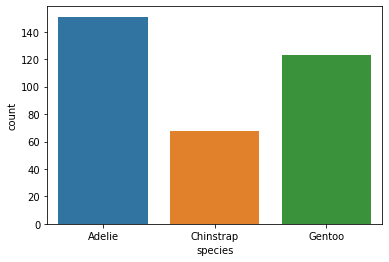

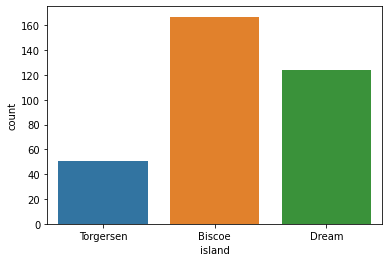

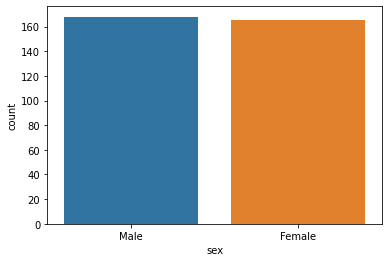

In [229]:
fig1 = plt.figure() #categorical data는 countplot 사용
sns.countplot(x = 'species', data = pgn)
fig2 = plt.figure()
sns.countplot(x = 'island', data = pgn)
fig3 = plt.figure()
sns.countplot(x = 'sex', data = pgn)

<AxesSubplot:xlabel='island', ylabel='sex'>

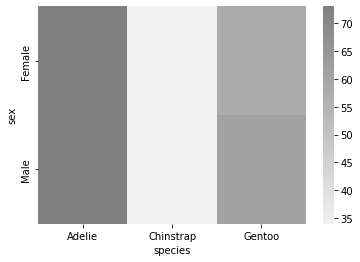

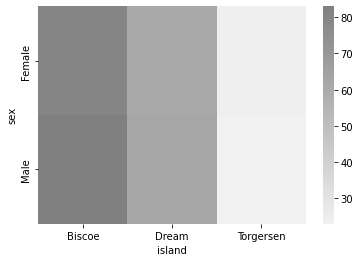

In [230]:
sex_spec = pgn.pivot_table(index = 'sex', columns = 'species', aggfunc = 'size') #종, 출신섬이 성별 분포에 영향을 주는지 확인
sex_isl = pgn.pivot_table(index = 'sex', columns = 'island', aggfunc = 'size')
fig1 = plt.figure()
sns.heatmap(sex_spec, cmap = sns.light_palette('gray', as_cmap=True))
fig2 = plt.figure()
sns.heatmap(sex_isl, cmap = sns.light_palette('gray', as_cmap=True))

인간의 경우에 자연 성비가 5:5가 아니듯이 종별 유전자의 특수성과 해당 섬의 식생이 성비와 상관관계가 있을 수 있다고 생각해
시각화를 통해 확인해 보았다.
결과적으로 섬, 출신섬별로 절대적인 개체수의 차이가 날 뿐 성별분포에 유의미한 영향을 준다고 보기는 힘들다.

<AxesSubplot:xlabel='island', ylabel='species'>

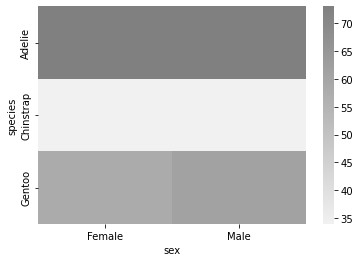

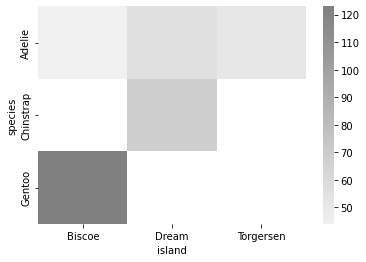

In [231]:
spec_sex = pgn.pivot_table(index = 'species', columns = 'sex', aggfunc = 'size')#성별, 출신섬이 종과 상관관계를 갖고 있는지 확인
spec_isl = pgn.pivot_table(index = 'species', columns = 'island', aggfunc = 'size')
fig1 = plt.figure()
sns.heatmap(spec_sex, cmap = sns.light_palette('gray', as_cmap=True))
fig2 = plt.figure()
sns.heatmap(spec_isl, cmap = sns.light_palette('gray', as_cmap=True))

위에서 확인한 바와 같이 성별과 종 간에는 큰 상관관계가 없지만 출신섬이 어디냐의 여부는 종과 유의미한 상관관계를 갖는다.

1.3

<AxesSubplot:xlabel='body_mass_g', ylabel='Density'>

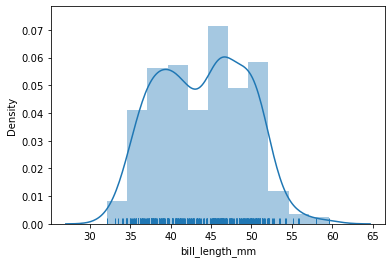

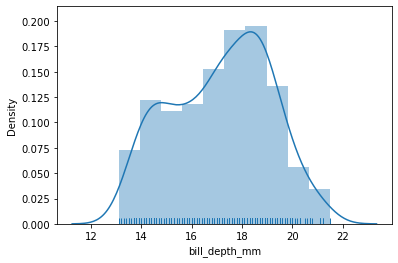

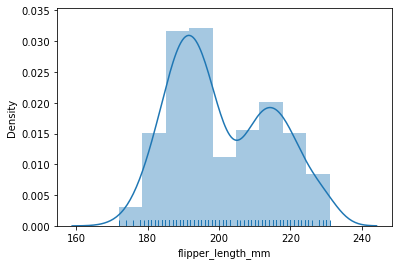

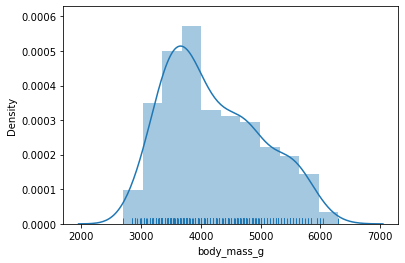

In [232]:
fig1 = plt.figure() #연속형 변수는 distplot 사용
sns.distplot(pgn['bill_length_mm'], kde = True, rug = True, )
fig2 = plt.figure()
sns.distplot(pgn['bill_depth_mm'], kde = True, rug = True, )
fig3 = plt.figure()
sns.distplot(pgn['flipper_length_mm'], kde = True, rug = True, )
fig4 = plt.figure()
sns.distplot(pgn['body_mass_g'], kde = True, rug = True, )

연속형 변수들의 경우 크게 skewed한 모습을 확인 할 순 없다. 하지만 단위가 mm, g이기 때문에 피처값이 너무 커지게 되는 문제를
갖는다. scaler 사용을 고려해야 할 부분이다. 다만 신체 특성상 중량, 너비, 길이에 따라 그 값들의 range에 유의미한 차이를 보일 수 밖에
없는데 이를 일괄적으로 scaler를 통해 값을 맞추는건 분류 모델의 성능을 떨어뜨릴 수 있다고 생각했다. 같은 mm, g단위를 갖고 있는 것만으로
충분하지 않을까 생각된다.

In [233]:
le = LabelEncoder() #categorical 변수는 간단하게 label econding 해준다.
spec = le.fit_transform(pgn['species']) #Adelie = 0, Chinstrap =1, Gentoo = 2
isl = le.fit_transform(pgn['island']) #Torgersen = 2, Biscoe = 1, Dream = 0
spec = pd.DataFrame(spec)
isl = pd.DataFrame(isl)
isl
#종과 출신섬간의 상관관계가 존재하기 때문에 one-hot ecoding을 할 필욘 없다고 판단했다.

,0
0,2
1,2
2,2
3,2
4,2
...,...
337,0
338,0
339,0
340,0


In [234]:
pgn['species'] = spec #econding 후의 dataframe
pgn['island'] = isl
pgn

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,Male
1,0,2,39.5,17.4,186.0,3800.0,Female
2,0,2,40.3,18.0,195.0,3250.0,Female
3,0,2,36.7,19.3,193.0,3450.0,Female
4,0,2,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
337,2,0,47.2,13.7,214.0,4925.0,Female
338,2,0,46.8,14.3,215.0,4850.0,Female
339,2,0,50.4,15.7,222.0,5750.0,Male
340,2,0,45.2,14.8,212.0,5200.0,Female


In [235]:
len(pgn) - pgn.count() #결측치가 성별에만 있음을 확인할 수 있다.

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

In [236]:
pgn.isnull()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
337,False,False,False,False,False,False,False
338,False,False,False,False,False,False,False
339,False,False,False,False,False,False,False
340,False,False,False,False,False,False,False


In [237]:
pgn_fls = pgn.isnull().any(axis=1)

In [238]:
pgn_fls

0      False
1      False
2      False
3      False
4      False
       ...  
337    False
338    False
339    False
340    False
341    False
Length: 342, dtype: bool

In [239]:
pgn_nan = pgn[pgn_fls] #결측치를 갖고 있는 dataframe만 떼어내서 새로운 dataframe으로 저장한다.
pgn_nan = pgn_nan.reset_index(drop=True)
pgn_nan

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,34.1,18.1,193.0,3475.0,NaN
1,0,2,42.0,20.2,190.0,4250.0,NaN
2,0,2,37.8,17.1,186.0,3300.0,NaN
3,0,2,37.8,17.3,180.0,3700.0,NaN
4,0,1,37.5,18.9,179.0,2975.0,NaN
5,2,0,44.5,14.3,216.0,4100.0,NaN
6,2,0,46.2,14.4,214.0,4650.0,NaN
7,2,0,47.3,13.8,216.0,4725.0,NaN
8,2,0,44.5,15.7,217.0,4875.0,NaN


In [240]:
for i in range(len(pgn_fls)):
    if pgn_fls[i] == False:
        pgn_fls[i] = True
    else:
        pgn_fls[i] = False

In [241]:
pgn_tru = pgn_fls

In [242]:
pgn_tru

0      True
1      True
2      True
3      True
4      True
       ... 
337    True
338    True
339    True
340    True
341    True
Length: 342, dtype: bool

In [243]:
pgn_full = pgn[pgn_tru] #결측치가 없는 dataframe만 떼어내서 새로운 dataframe으로 저장한다.
pgn_full = pgn_full.reset_index(drop=True)
pgn_full

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,Male
1,0,2,39.5,17.4,186.0,3800.0,Female
2,0,2,40.3,18.0,195.0,3250.0,Female
3,0,2,36.7,19.3,193.0,3450.0,Female
4,0,2,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
328,2,0,47.2,13.7,214.0,4925.0,Female
329,2,0,46.8,14.3,215.0,4850.0,Female
330,2,0,50.4,15.7,222.0,5750.0,Male
331,2,0,45.2,14.8,212.0,5200.0,Female


In [244]:
encoder = OneHotEncoder(drop='first', sparse=False) #성별은 one-hot enocder를 이용해서 변환한다. male = 1, female = 0
enc = pd.DataFrame(encoder.fit_transform(pgn_full[['sex']]))
pgn_full['sex'] = enc
pgn_full

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1.0
1,0,2,39.5,17.4,186.0,3800.0,0.0
2,0,2,40.3,18.0,195.0,3250.0,0.0
3,0,2,36.7,19.3,193.0,3450.0,0.0
4,0,2,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...,...,...
328,2,0,47.2,13.7,214.0,4925.0,0.0
329,2,0,46.8,14.3,215.0,4850.0,0.0
330,2,0,50.4,15.7,222.0,5750.0,1.0
331,2,0,45.2,14.8,212.0,5200.0,0.0


2.

In [245]:
pgn_mice = pd.concat([pgn_full, pgn_nan], axis=0) #mice이용을 위한 dataframe, concat을 이용해 nan, full dataframe을 인덱스 단위로 붙여준다.
pgn_mice = pgn_mice.reset_index(drop=True)
pgn_mice = pgn_mice.drop(['species', 'island'], axis=1) #출신섬, 종은 성별과 큰 상관관계를 갖지 않는다고 판단, 성별과 종도 학습 데이터에서 제외했다.
pgn_mice

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
3,36.7,19.3,193.0,3450.0,0.0
4,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...
337,37.5,18.9,179.0,2975.0,NaN
338,44.5,14.3,216.0,4100.0,NaN
339,46.2,14.4,214.0,4650.0,NaN
340,47.3,13.8,216.0,4725.0,NaN


In [246]:
x_train = pgn_full.drop(['sex', 'species', 'island'], axis=1) #logistic regression 학습을 위한 데이터 분리
y_train = pgn_full['sex'] #출신섬, 종은 성별과 큰 상관관계를 갖지 않는다고 판단, 성별과 종도 학습 데이터에서 제외했다.

In [247]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pdt = logreg.predict(x_train)
print((accuracy_score(y_pdt, y_train))*100)
print(type(y_pdt))

90.990990990991
<class 'numpy.ndarray'>


90%의 정확도를 가진다

In [248]:
x_test = pgn_nan.drop(['sex', 'species', 'island'], axis=1) #logistic 예측 결과
sex_reg = pd.DataFrame(logreg.predict(x_test))
pgn_nan['sex'] = sex_reg
pgn_nan

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,34.1,18.1,193.0,3475.0,0.0
1,0,2,42.0,20.2,190.0,4250.0,1.0
2,0,2,37.8,17.1,186.0,3300.0,0.0
3,0,2,37.8,17.3,180.0,3700.0,0.0
4,0,1,37.5,18.9,179.0,2975.0,0.0
5,2,0,44.5,14.3,216.0,4100.0,0.0
6,2,0,46.2,14.4,214.0,4650.0,0.0
7,2,0,47.3,13.8,216.0,4725.0,0.0
8,2,0,44.5,15.7,217.0,4875.0,1.0


In [249]:
pgn_logfull = pd.concat([pgn_full, pgn_nan], axis=0) #imputation 마친 데이터와 결측값 없던 데이터를다시 합침
pgn_logfull = pgn_logfull.reset_index(drop=True)
pgn_logfull

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1.0
1,0,2,39.5,17.4,186.0,3800.0,0.0
2,0,2,40.3,18.0,195.0,3250.0,0.0
3,0,2,36.7,19.3,193.0,3450.0,0.0
4,0,2,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...,...,...
337,0,1,37.5,18.9,179.0,2975.0,0.0
338,2,0,44.5,14.3,216.0,4100.0,0.0
339,2,0,46.2,14.4,214.0,4650.0,0.0
340,2,0,47.3,13.8,216.0,4725.0,0.0


In [286]:
imp_mean = IterativeImputer(random_state=0) #mice 이용한 imputation
imp_mean.fit(pgn_mice)
pgn_imp = pd.DataFrame(imp_mean.transform(pgn_mice))
pgn_imp

,0,1,2,3,4
0,39.1,18.7,181.0,3750.0,1.000000
1,39.5,17.4,186.0,3800.0,0.000000
2,40.3,18.0,195.0,3250.0,0.000000
3,36.7,19.3,193.0,3450.0,0.000000
4,39.3,20.6,190.0,3650.0,1.000000
...,...,...,...,...,...
337,37.5,18.9,179.0,2975.0,0.226995
338,44.5,14.3,216.0,4100.0,-0.085449
339,46.2,14.4,214.0,4650.0,0.206379
340,47.3,13.8,216.0,4725.0,0.138978


mice의 경우 binary 형태가 아닌 실수값으로 예측값을 전달한다. threshold를 따로 설정해야 할 듯 하다. 이후 분석에서는
logistic regression을 통해 얻은 pgn_logfull data로 분석을 진행하겠다

3.

In [287]:
x_train, x_test, y_train, y_test = train_test_split(pgn_logfull.drop(['species'], axis=1), pgn_logfull['species'], test_size=0.3, shuffle=True, )
#종 분류모델 학습을 위한 데이터 분류

In [288]:
MNLogit = sm.MNLogit(y_train, sm.add_constant(x_train)) #multinomial model 이용 
MNLogit
logit = MNLogit.fit_regularized(start_params=None, method='l1', maxiter='defined_by_method', full_output=1, disp=1, callback=None, alpha=0, trim_mode='auto', auto_trim_tol=0.01, size_trim_tol=0.0001, qc_tol=0.03)
print(logit.summary())
print(logit.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.813957582154638e-09
            Iterations: 52
            Function evaluations: 74
            Gradient evaluations: 52
                          MNLogit Regression Results                          
Dep. Variable:                species   No. Observations:                  239
Model:                        MNLogit   Df Residuals:                      225
Method:                           MLE   Df Model:                           12
Date:                Sun, 16 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        15:56:34   Log-Likelihood:            -1.8675e-06
converged:                       True   LL-Null:                       -251.65
Covariance Type:            nonrobust   LLR p-value:                4.385e-100
        species=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

솔직히 multinomial model의 이론적 백그라운드는 아직 잘 이해하지 못했다. 카카오 데이터 센터에 불이 나서 티스토리가 죄다 먹통이라
구글링에도 한계가 있었다.
다만 p-value와 분산이 굉장히 크거나 nan값이 나오는걸 봐서 각 피처들의 coefficient는 유의미 하지 않다고 보는게 합리적인것 같다.

In [289]:
y_pdt = logit.predict(sm.add_constant(x_test))
y_pdt

,0,1,2
92,1.000000e+00,2.314124e-102,2.868223e-109
148,2.137145e-135,1.000000e+00,2.540822e-135
46,1.000000e+00,4.654751e-142,1.689108e-136
161,2.635217e-78,1.000000e+00,2.162976e-95
36,1.000000e+00,7.751486e-79,1.775691e-91
...,...,...,...
58,1.000000e+00,4.792609e-53,4.236466e-98
117,1.000000e+00,1.800169e-86,4.074135e-92
110,1.000000e+00,5.815343e-34,2.365622e-80
296,1.456422e-155,6.440227e-69,1.000000e+00


이런식으로 실수 값으로 나온다.

In [290]:
pdt = pd.DataFrame(logit.predict(sm.add_constant(x_test)) > 0.5, dtype=float) #정수형으로 볂환
pdt

,0,1,2
92,1.0,0.0,0.0
148,0.0,1.0,0.0
46,1.0,0.0,0.0
161,0.0,1.0,0.0
36,1.0,0.0,0.0
...,...,...,...
58,1.0,0.0,0.0
117,1.0,0.0,0.0
110,1.0,0.0,0.0
296,0.0,0.0,1.0


In [291]:
p = pd.DataFrame(logit.pred_table())
p

,0,1,2
0,108.0,0.0,0.0
1,0.0,50.0,0.0
2,0.0,0.0,81.0


일단 테스트 데이터는 다 맞혔다. 추정계수가 의미하는 바는 모르겠지만 분류모델로서는 훌륭한거 같다.

In [292]:
mn = sm.MNLogit(y_test, sm.add_constant(x_test))
lg = mn.fit_regularized(start_params=None, method='l1', maxiter='defined_by_method', full_output=1, disp=1, callback=None, alpha=0, trim_mode='auto', auto_trim_tol=0.01, size_trim_tol=0.0001, qc_tol=0.03)
p2 = pd.DataFrame(lg.pred_table())
p2

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.962649725404059e-06
            Iterations: 49
            Function evaluations: 133
            Gradient evaluations: 49


,0,1,2
0,43.0,0.0,0.0
1,0.0,18.0,0.0
2,0.0,0.0,42.0


테스트 데이터도 돌려봤다. 트레이닝 데이터로 학습한 모델을 가지고 테스트 데이터를 predict 하는 방법은 못 찾겠어서 테스트 데이터로 새로
학습시킨 뒤에 분류를 시켰다. 그럼에도 여전히 훌륭한 성능을 보여준다

4.2

In [293]:
rc = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs') #ridge classifier 사용
rc.fit(x_train, y_train)
y_pdt = rc.predict(x_test)

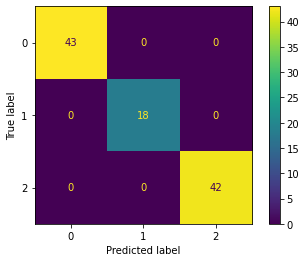

In [294]:
plt1 = plot_confusion_matrix(rc, x_test, y_test)
plt1

ridge의 성능도 준수하다.

4.2

In [298]:
lc1 = LogisticRegression(penalty='l1', solver='liblinear')
gs1 = GridSearchCV(estimator=lc1, param_grid={'C':[1, 10]}, cv=8, scoring='accuracy')
gs1.fit(x_train, y_train)
print(gs1.best_params_)
print(gs1.best_score_)

{'C': 1}
0.9875


In [299]:
lc1 = LogisticRegression(penalty='l1', solver='liblinear')
gs1 = GridSearchCV(estimator=lc1, param_grid={'C':[1, 500]}, cv=8, scoring='accuracy')
gs1.fit(x_train, y_train)
print(gs1.best_params_)
print(gs1.best_score_)

{'C': 500}
0.9916666666666667


In [300]:
lc2 = LogisticRegression(penalty='l1', solver='saga')
gs2 = GridSearchCV(estimator=lc2, param_grid={'C':[0.5, 0.6]}, cv=8, scoring='accuracy')
gs2.fit(x_train, y_train)
print(gs2.best_params_)
print(gs2.best_score_)

{'C': 0.5}
0.6360632183908046


In [301]:
lc2 = LogisticRegression(penalty='l1', solver='saga')
gs2 = GridSearchCV(estimator=lc2, param_grid={'C':[1, 100]}, cv=8, scoring='accuracy')
gs2.fit(x_train, y_train)
print(gs2.best_params_)
print(gs2.best_score_)

{'C': 1}
0.6360632183908046


In [302]:
lc2 = LogisticRegression(penalty='l1', solver='saga')
gs2 = GridSearchCV(estimator=lc2, param_grid={'C':[100]}, cv=8, scoring='accuracy')
gs2.fit(x_train, y_train)
print(gs2.best_params_)
print(gs2.best_score_)

{'C': 100}
0.6360632183908046


Lasso의 경우 slover가 'liblinear', 'saga'인 경우에만 logisticregression이 작동이 된다.
solver가 'liblinear'인 경우에는 C값이 크면 클수록 정확도가 높아지는 모습을 보이는데
'saga'의 경우 C값과 무관하게 정확도가 일정한 모습을 볼 수 있다.

In [303]:
lc1 = LogisticRegression(penalty='l1', C=5000, solver='liblinear')
lc1.fit(x_train, y_train)
y_pdt = rc.predict(x_test)

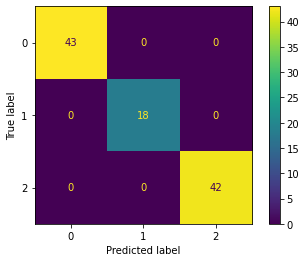

In [304]:
plt2 = plot_confusion_matrix(lc1, x_test, y_test)
plt2

solver가 'liblinear'일때, C값을 매우 크게 잡고 분류모델을 학습한 경우다. 준수한 성능을 보이는 모습을 확인할 수 있다.

In [305]:
lc2 = LogisticRegression(penalty='l1', C=1, solver='saga')
lc2.fit(x_train, y_train)
y_pdt = rc.predict(x_test)

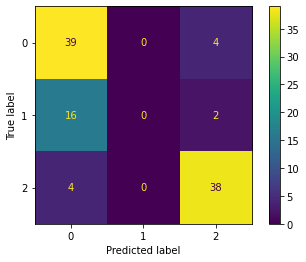

In [306]:
plt3= plot_confusion_matrix(lc2, x_test, y_test)
plt3

solver가 'saga'일 때는 유의미한 C값의 따른 성능의 차이가 없기 때문에 C를 그냥 1로 놓고 모델을 학습시켰다.
'liblinear'의 비해 굉장히 떨어지는 성능을 보인다.

4.3

sklearn official documentation에 따르면 l1 penalty를 지원하는 solver는 'liblinear'와 'saga'밖에 없다.
'liblinear'는 데이터셋의 숫자가 작을때 우수하고 'saga'는 데이터 셋이 클 때 속도가 빠르다는 장점이 있다고 한다.
아마 penguins 데이터 숫자가 약 300개에 불과했기 때문에 'liblinear'가 더 우수한 성능을 보인것이 아닌가 싶다.
또한 'liblinear'의 경우 OVR multiclass classification에서 한계를 보인단고 한다.